# **Introduction to Deep Learning: Final Project**

**Submitted by:**

Roei Matz       205871478

Yotam Silverman 313532418

# Project Description

The data for this project was gathered from the [sign language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset from the website kaggle.com.


The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

Our project's objective is to design and build a neural network that will identify the letters given in each image.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# CapsNet related imports
import os
import pandas as pd
from sklearn.metrics import accuracy_score
# # clone package repository
# !git clone https://github.com/jindongwang/Pytorch-CapsuleNet.git

# # navigate to directory
# %cd Pytorch-CapsuleNet

# # get modifications made on the repo
# !git pull origin master

# # import it
# from capsnet import CapsNet
#

import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

Mount Google Drive and load the project's data:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
x_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,1:]
x_test = np.genfromtxt(test_csv, delimiter=',')[1:,1:]

train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
t_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,0]
t_test =  np.genfromtxt(test_csv, delimiter=',')[1:,0]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Splitting the train set to train and validation

In [3]:
x_train = x_train_val[0:round(0.8*len(x_train_val))]
x_val = x_train_val[round(0.8*len(x_train_val)):]

t_train = t_train_val[0:round(0.8*len(t_train_val))]
t_val = t_train_val[round(0.8*len(t_train_val)):]

Making a dictionary for the alphabet:

In [4]:
import string
alphabet_dict = dict(zip(range(0,26),string.ascii_uppercase))

print(alphabet_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Here, we show few examples of the letters notions in the sign language:

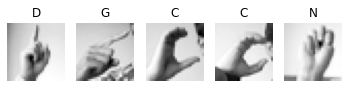

In [ ]:
plt.figure(figsize=(6, 3))
for i in range(0,5): 
  plt.subplot(1, 5, i + 1)
  img = x_train[i]
  img = np.reshape(img, (28, 28))
  plt.imshow(img, cmap='Greys_r')
  plt.title(alphabet_dict[int(t_train[i])])
  plt.axis('off');

Normalizing the data set:

In [5]:
def img_norm(data):
  output = []
  for img in data: 
    img = (img - np.mean(img))/np.std(img)  #zero mean and a unit standard deviation
    output.append(np.array(img))
  return np.array(output)

# def img_norm(data): # 63% accuracy
#   output = []
#   for img in data: 
#     img = img/255                        #pixels' values between 0 to 1
#     output.append(np.array(img))
#   return np.array(output)

# def img_norm(data): # 78% accuracy
#   output = []
#   for img in data: 
#     img = img/255 - 0.5                 #pixels' values between -0.5 to 0.5
#     output.append(np.array(img))
#   return np.array(output)

x_train_norm = img_norm(x_train)
x_val_norm = img_norm(x_val)
x_test_norm = img_norm(x_test)

train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    np.concatenate((t_val[:,None], x_val_norm),axis=1),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=64, shuffle=True)

After checking the network with several normalztions techniques, such as: dividing each image by 255 so we will have values between 0 and 1, and also subtracting 0.5 so that the elements of will be between -0.5 and 0.5, we chose to normalize by subtracting the mean of each image and dividing the standard deviation. This normaliztion provided the best accuracy with our models.

Defining CNN:

In [6]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

def get_accuracy(model, loader=train_loader):
    model.eval()
    loss = 0
    correct = 0
    pred_list = []
    true_list = []
    for ar in loader:
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)
        pred = model(data)
        loss += F.nll_loss(pred, label.long(), reduction='sum').item() # sum up batch loss                                                               
        pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()
 
        for y in pred.squeeze(1):
          pred_list.append(y.cpu())

        for y in label:  
          true_list.append(y.cpu())
          
    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))    
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    
    return loss, accuracy, conf_mat

def show_confusion_matrix(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))])
    fig, ax = plt.subplots(figsize=(14, 12))
    ax.set_xlabel('Preicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16) 
    disp.plot(ax=ax)

def train(model, lr=0.01, momentum=0.5, max_iters=1000,num_epochs=6):
    model.train()
    train_accs, valid_accs = [], []
    epochs = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    n = 0 # the number of iterations
    iters, losses = [], []
    iters_sub = []

    for epoch in range(0, num_epochs):

        for batch_idx, ar in enumerate(train_loader):           
            data = ar[:,1:]
            label = ar[:,0]
            # send to device
            data, label = data.to(device), label.to(device)
            data = data.view(-1, 28*28)
            data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            pred = model(data)
            loss = F.nll_loss(pred, label.long())
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(loss)

            if batch_idx % 64 == 0: 
                
                iters_sub.append(n)
                train_loss, train_acc, _ = get_accuracy(model, loader=train_loader)
                train_accs.append(train_acc)

                valid_loss, valid_acc, _ = get_accuracy(model, loader=val_loader)
                valid_accs.append(valid_acc)
      
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (n, valid_acc, train_acc, train_loss))

            # increment the iteration number
            n += 1
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, valid_accs
    return iters, losses, iters_sub, train_accs, valid_accs
            


In [ ]:
# Training settings 
n_features = 10 # number of feature maps

input_size  = 28*28   # images are 28x28 pixels
output_size = 26      # there are 26 classes

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

lr = 0.001
momentum = 0.1

iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn.double(), lr=lr, momentum=momentum, max_iters=640,num_epochs=6)

Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 3.273165]
Iter 64. [Val Acc 36%] [Train Acc 36%, Loss 2.032217]
Iter 128. [Val Acc 61%] [Train Acc 61%, Loss 1.241773]
Iter 192. [Val Acc 74%] [Train Acc 74%, Loss 0.813091]
Iter 256. [Val Acc 84%] [Train Acc 85%, Loss 0.534630]
Iter 320. [Val Acc 88%] [Train Acc 88%, Loss 0.403982]
Iter 344. [Val Acc 87%] [Train Acc 88%, Loss 0.405595]
Iter 408. [Val Acc 93%] [Train Acc 93%, Loss 0.259389]
Iter 472. [Val Acc 96%] [Train Acc 96%, Loss 0.187306]
Iter 536. [Val Acc 95%] [Train Acc 96%, Loss 0.155347]
Iter 600. [Val Acc 98%] [Train Acc 98%, Loss 0.095787]


We plot the learning curves: the training loss curve and the training and validation accuracies curves.

In [10]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

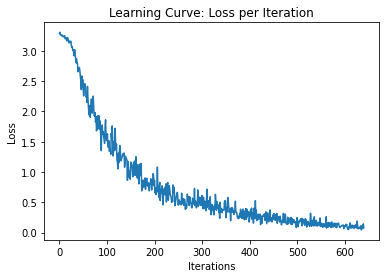

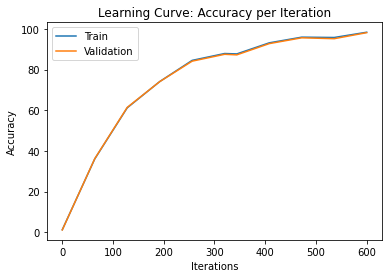

In [ ]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

We check our model performance by calculating the loss and the accuracy of the model with the test set.

Test set: Average loss: 0.538515, Accuracy: 84%


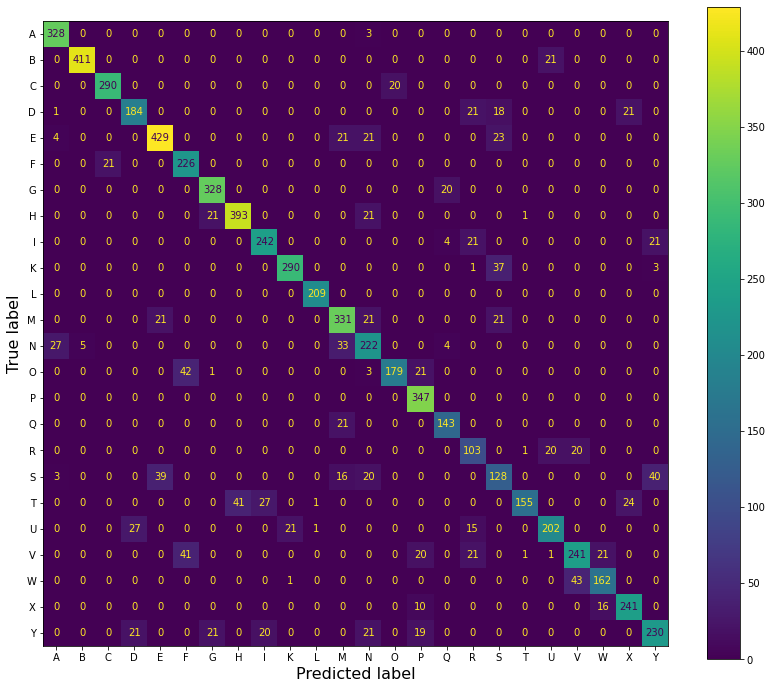

In [ ]:
test_loss, test_acc, test_conf_mat = get_accuracy(model_cnn,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(test_conf_mat)

Displaying some of our results:

In [ ]:
num_of_samples = 5
for i in range(0,num_of_samples):
  data = x_test_norm[i]
  img = np.reshape(data, (28, 28)) 
  data = torch.Tensor(data).view(-1, 28*28)
  data = data.view(-1, 1, 28, 28) 
  pred = model_cnn(data.double())
  pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                  
  plt.figure(figsize=(2, 1))
  plt.imshow(img, cmap='Greys_r')
  plt.title(f"True label:{alphabet_dict[int(t_test[i])]}, Predicted label: {alphabet_dict[int(pred)]}")
  plt.axis('off');

RuntimeError: ignored

Here, we implemented a novel network called CapsNet:

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torch.autograd import Variable
# from torchvision import datasets, transforms
# from capsnet import CapsNet
# from data_loader import Dataset
from tqdm import tqdm

USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 64
N_EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
n_features = 10
'''
Config class to determine the parameters for capsule net
'''

class Config:
    def __init__(self):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9

        # Primary Capsule (pc)
        self.pc_num_capsules = 8
        self.pc_in_channels = 256
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_num_routes = 32 * 6 * 6

        # Digit Capsule (dc)
        self.dc_num_capsules = 26
        self.dc_num_routes = 32 * 6 * 6
        self.dc_in_channels = 8
        self.dc_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28

from torch.autograd import Variable

USE_CUDA = True if torch.cuda.is_available() else False

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 26, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_width * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(26))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked


class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
            self.decoder = Decoder(config.input_width, config.input_height, config.cnn_in_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()
            self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

# def new_margin_loss(x, labels, size_average=True):
#         batch_size = x.size(0)

#         v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

#         left = F.relu(0.9 - v_c).view(batch_size, -1)
#         right = F.relu(v_c - 0.1).view(batch_size, -1)
#         loss = labels * left + 0.5 * (1.0 - labels) * right
#         loss = loss.sum(dim=1).mean()

#         return loss

def train_capsnet(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    for batch_id, ar in enumerate(train_loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.item()
        total_loss += train_loss
        if batch_id % 100 == 0:
            current_acc, current_loss, _ = get_accuracy_capsnet(capsule_net, train_loader)
            # tqdm.write(
            #     "Epoch: [{}/{}], train accuracy: {:.6f}%, loss: {:.6f}".format(e, N_EPOCHS, valid_acc,
            #                                                               valid_loss / len(val_loader)))
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}%, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                current_acc,
                current_loss
                ))
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))


def get_accuracy_capsnet(capsule_net, loader):
    capsule_net.eval()
    final_loss = 0
    correct = 0

    pred_list = []
    true_list = []
    for batch_id, ar in enumerate(loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        final_loss += loss.item()
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))
        
        for y in np.argmax(masked.data.cpu().numpy(), 1):
          pred_list.append(y)

        for y in np.argmax(target.data.cpu().numpy(), 1):  
          true_list.append(y)

    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))  
    acc = correct * 100 / len(loader.dataset)
    
    return acc, final_loss, conf_mat

In [25]:
torch.manual_seed(1)
config = Config()

capsule_net = CapsNet_new(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()

optimizer = torch.optim.Adam(capsule_net.parameters())
capsule_net.margin_loss = new_margin_loss
for e in range(1, N_EPOCHS + 1):
    train_capsnet(capsule_net, optimizer, train_loader, e)
    valid_acc, valid_loss, _ = get_accuracy_capsnet(capsule_net, val_loader)
    tqdm.write(
        "Epoch: [{}/{}], validation accuracy: {:.6f}%, loss: {:.6f}".format(e, N_EPOCHS, valid_acc,
                                                                  valid_loss / len(val_loader)))

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet.pt")

RuntimeError: ignored

In [ ]:
from datetime import datetime

now = datetime.now() 
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

torch.save(capsule_net.state_dict(),  "/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_" + dt_string + ".pt")

test accuracy: 95.343001%, loss: 0.265509


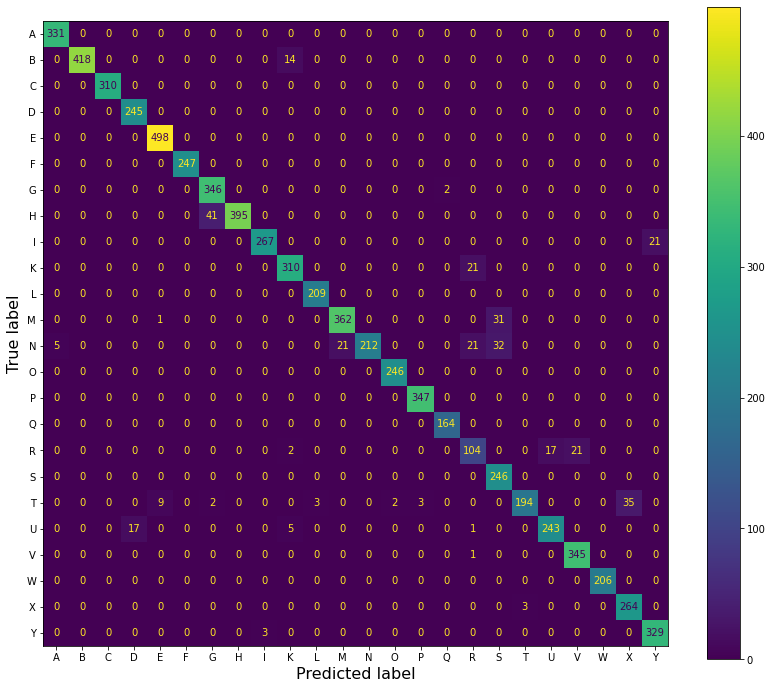

In [ ]:
torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()
capsule_net.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/Project/capsnet_07_01_2022_13_50_36.pt'))

test_acc, test_loss, test_conf_mat = get_accuracy_capsnet(capsule_net, test_loader)
tqdm.write(
    "test accuracy: {:.6f}%, loss: {:.6f}".format(test_acc, test_loss / len(test_loader)))
show_confusion_matrix(test_conf_mat)

In [7]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=480, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=26)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool1(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
model_lenet = LeNet5()
model_lenet.to(device)

lr = 0.001
momentum = 0.1

iters, losses, iters_sub, train_accs, valid_accs = train(model_lenet.double(), lr=lr, momentum=momentum, max_iters=1000,num_epochs=10)

Iter 0. [Val Acc 8%] [Train Acc 8%, Loss 3.236589]
Iter 64. [Val Acc 56%] [Train Acc 55%, Loss 1.750574]
Iter 128. [Val Acc 67%] [Train Acc 68%, Loss 1.208585]
Iter 192. [Val Acc 78%] [Train Acc 78%, Loss 0.892094]
Iter 256. [Val Acc 86%] [Train Acc 86%, Loss 0.666538]
Iter 320. [Val Acc 91%] [Train Acc 91%, Loss 0.502070]
Iter 344. [Val Acc 92%] [Train Acc 92%, Loss 0.451483]
Iter 408. [Val Acc 94%] [Train Acc 95%, Loss 0.344788]
Iter 472. [Val Acc 97%] [Train Acc 97%, Loss 0.264223]
Iter 536. [Val Acc 97%] [Train Acc 98%, Loss 0.201447]
Iter 600. [Val Acc 98%] [Train Acc 99%, Loss 0.156170]
Iter 664. [Val Acc 99%] [Train Acc 99%, Loss 0.125211]
Iter 688. [Val Acc 99%] [Train Acc 99%, Loss 0.114312]
Iter 752. [Val Acc 99%] [Train Acc 100%, Loss 0.089490]
Iter 816. [Val Acc 100%] [Train Acc 100%, Loss 0.071051]
Iter 880. [Val Acc 100%] [Train Acc 100%, Loss 0.057638]
Iter 944. [Val Acc 100%] [Train Acc 100%, Loss 0.047805]


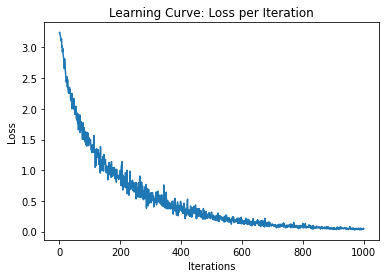

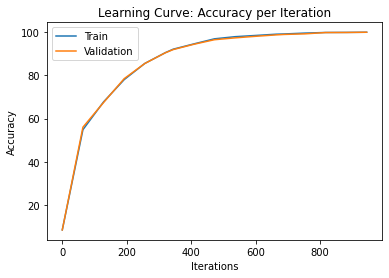

In [12]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

Test set: Average loss: 0.381608, Accuracy: 87%


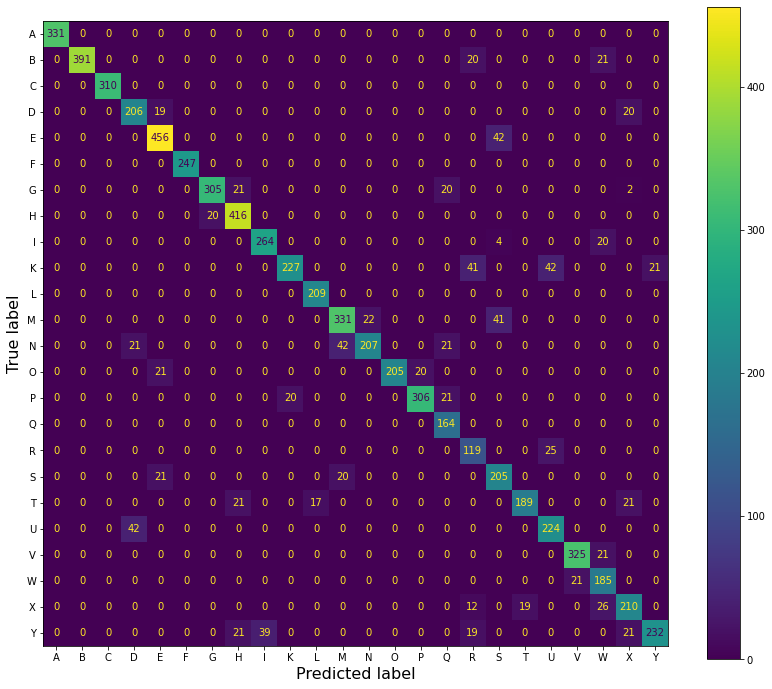

In [13]:
test_loss, test_acc, test_conf_mat = get_accuracy(model_lenet,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(test_conf_mat)